In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.linalg as LA
from sklearn.datasets import fetch_openml
import copy
import itertools
import time

In [2]:
# For the MNIST data, there are 10 classes of digits
num_classes = 10

In [3]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
        
    return np.array(ims['Image'].to_list())

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    
    total = 0
        
    for key in data:
        print('{} examples of digit {}'.format(len(data[key]), key))
        total += len(data[key])
    print('{} examples in total\n'.format(total))
    return None

def sim_frob(A, B):
    """ Take in a tuple of data vectors and compute the similarity of the vectors. 
    
        The similarity is computed as <A, B>/(||A||*||B||), where < , > is the 
        standard inner product on R^N.
        
        For the MNIST dataset, images are not reshaped to square.
    """

    return np.dot(A,B)/(np.sqrt(np.dot(A,A))*np.sqrt(np.dot(B,B)))

def get_coords(data):
    """ Each returned tuple corresponds to a pair of images that will be compared, where
        the indices point to the respective image indices in 'data'.
        
        Input:
        ------
        data := list or NumPy array containing image data
        
        Returns:
        -------
        coords := array of tuples corresponding to the indices of each pairwise comparison
    """
    
    n = len(data)
    
    # This generates the Cartesian product of indices of 'data'
    all_comparisons = list(itertools.product(range(n), range(n)))

    # This generates the pairwise comparisons we wish to make (only those above the main diagonal)
    coords = list((i,j) for i,j in all_comparisons if i < j)
    
    return coords

def get_similarity(data, sim_func = sim_frob, coords = None):
    """ Take in array of 'data' and perform pairwise comparisons of
        images. The images to be compared are calculated by the
        'get_coords()' function.
        
        Note: This function computes self-similarity of a single class.
              To compare two classes, use the 'cross_comparison' function.
        
        Inputs:
        -------
        data := list or NumPy array containing image data
        coords := a list of indices corresponding to comparisons that will be made
        sim_func := the function to use for calculating similarity
        
        Returns:
        -------
        similarity := array of pairwise similarity comparisons, calculated by the 'sim' function
    """
    
    if coords:
        # Calculate the similarity
        similarity = np.array(list(sim_func(data[i], data[j]) for i,j in coords))
        
    else:
        # Find the indices of images that will be compared
        coords = get_coords(data)
    
        # Calculate the similarity
        similarity = np.array(list(sim_func(data[i], data[j]) for i,j in coords))
    
    return similarity

In [4]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images1 = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# By default, the 'Class label' column is not integer, so we'll convert it here.
images1['Class label'] = images1['Class label'].astype(int)

In [6]:
""" This saves all images in each digit class to a dictionary.
    The dictionary keys correspond to the digit classes and the
    value for each key is a NumPy array of images.
"""

data = {digit: extract_image(images1, digit) for digit in range(num_classes)}
display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



In [7]:
""" This step is to extract a training set from the complete set of digits. 
    For now, we'll take the first 'n_samples' digits as our training data.
"""

n_samples = 150

train = {digit: data[digit][:n_samples] for digit in range(num_classes)}

In [11]:
def get_chain(data):    
    """ Take in an array of image data and return the sorted chain of indices.
    """
    n = len(data)
    
    all_coords = get_coords(data)
    
    similarity = get_similarity(data, all_coords)
    least_similar = np.argmin(similarity)
    
    # Apr 10 - experiment with argmax instead of argmin
#     least_similar = np.argmax(similarity)
    start_coords = all_coords[least_similar]
    start_index = start_coords[0]
    print('Using image {} as the starting point...'.format(start_index))
    
    # We don't want to compare the image at 'start_index' to itself
    indices_to_compare = [i for i in range(n) if i != start_index]
    
    # This gets the coordinates for image comparisons relative to the 'start_index'
    coords = list(itertools.product([start_index], indices_to_compare))

    # This computes the similarity relative to 'start_index'
    similarity_relative_to_start_index = get_similarity(data, coords)

    length = len(similarity_relative_to_start_index)
    
    chain = list(zip(similarity_relative_to_start_index, range(length)))
    chain.sort(reverse = True)

    return chain

In [12]:
DIGIT = 8

In [13]:
chain = get_chain(train[DIGIT])

TypeError: 'list' object is not callable

In [14]:
indices = [item[1] for item in chain]

NameError: name 'chain' is not defined

In [ ]:
im = train[DIGIT][indices]
im = [i.reshape((28,28)) for i in im]

In [ ]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = [[plt.imshow(i, cmap = 'gray')] for i in im]

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()

# 16 April 2020

This section compares each class with every other class to get the $10\times 10$ similarity matrix.

In [9]:
def sim_frob(A, B):
    """ Take in a tuple of data vectors and compute the similarity of the vectors. 
    
        The similarity is computed as <A, B>/(||A||*||B||), where < , > is the 
        standard inner product on R^N.
        
        For the MNIST dataset, images are not reshaped to square.
    """

    return np.dot(A,B)/(np.sqrt(np.dot(A,A))*np.sqrt(np.dot(B,B)))

def diff(A, B):
    """ Compute the distance between two vectors, scaled by their norms. """
    return np.dot(A-B, A-B)/(np.sqrt(np.dot(A,A))*np.sqrt(np.dot(B,B)))

def get_coords(data, within_class = False):
    """ Each returned tuple corresponds to a pair of images that will be compared, where
        the indices point to the respective image indices in 'data'.
        
        Input:
        ------
        data := list or NumPy array containing image data
        within_class := boolean; indicates if the returned index pairs will be
                        used to perform in-class comparisons
        
        Returns:
        -------
        coords := array of tuples corresponding to the indices of each pairwise comparison
    """
    
    n = len(data)
    
    # This generates the Cartesian product of indices of 'data'
    all_comparisons = list(itertools.product(range(n), range(n)))
    
    if within_class:
        # Only used when we want to compare a class to itself
        coords = list((i,j) for i,j in all_comparisons if i <= j)
    else:
        # This generates the pairwise comparisons we wish to make (only those above the main diagonal)
        coords = list((i,j) for i,j in all_comparisons if i < j)
    
    return coords

def cross_comp(data1, data2, coords, sim_func = sim_frob):
    """ Take in two arrays of data and compute their similarity
        using the similarity metric defined by 'sim_func'.
    """
    
    # Comparing using 'coords' avoids redundant comparisons
    similarity = np.array(list(sim_func(data1[i], data2[j]) for i,j in coords))
    
    return np.max(similarity)

def compare_classes(train):
    """ Take in a training set and compare the similarity of classes. 
    
        The similarity of two classes is defined as the maximum similarity 
        between any two digits from the classes.
        
        We will assume that each class has equal representation in the
        training set. That is, the array containing each class is the same size.
    """
    
    # All classes have the same amount of examples, so just pick any class to get the comparison indices
    indices_to_compare = get_coords(train[0])
    
    # Find the class comparisons we'll be making i.e. (0,0), (0,1), (0,2), ... , (8,9), (9,9)
    classes_to_compare = get_coords(train, within_class = True)
    
    return list(cross_comp(train[class_one],train[class_two],indices_to_compare) for class_one, class_two in classes_to_compare)

In [15]:
# Compare all classes to each other
result = compare_classes(train)

In [11]:
n_classes = 10

upper_idx = np.triu_indices(n_classes, k=0, m=n_classes)
matrix = np.zeros((n_classes, n_classes))
matrix[upper_idx] = result

result_matrix = matrix + matrix.T - np.eye(n_classes)*np.diag(matrix)

df = pd.DataFrame(result_matrix)

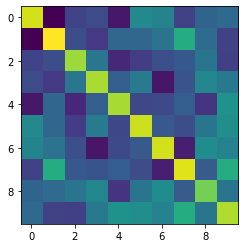

In [12]:
plt.imshow(df);

In [13]:
df

,0,1,2,3,4,5,6,7,8,9
0,0.951437,0.588851,0.667573,0.677009,0.613841,0.772089,0.762501,0.663722,0.714079,0.721940
1,0.588851,0.976549,0.682242,0.653904,0.717334,0.716833,0.736167,0.828837,0.723830,0.663931
2,0.667573,0.682242,0.919917,0.741714,0.631778,0.658668,0.683165,0.695631,0.738963,0.662168
3,0.677009,0.653904,0.741714,0.926677,0.704044,0.749320,0.611760,0.690037,0.767368,0.745509
4,0.613841,0.717334,0.631778,0.704044,0.925939,0.672779,0.674529,0.705036,0.648222,0.786631
5,0.772089,0.716833,0.658668,0.749320,0.672779,0.944930,0.697159,0.680977,0.739209,0.779759
6,0.762501,0.736167,0.683165,0.611760,0.674529,0.697159,0.950381,0.620829,0.778061,0.761495
7,0.663722,0.828837,0.695631,0.690037,0.705036,0.680977,0.620829,0.957271,0.699619,0.828861
8,0.714079,0.723830,0.738963,0.767368,0.648222,0.739209,0.778061,0.699619,0.895092,0.739566
9,0.721940,0.663931,0.662168,0.745509,0.786631,0.779759,0.761495,0.828861,0.739566,0.930025


In [14]:
train[0][0].reshape((28,28))

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0